In [3]:
import cv2
import os
import glob
import torch
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

/home/alexander/miniforge3/envs/data_challenges/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("breezedeus/coin-clip-vit-base-patch32", use_safetensors=True).to(device)


processor = CLIPProcessor.from_pretrained("breezedeus/coin-clip-vit-base-patch32")

image_input_paths = glob.glob("../bueschelquinare_preprocessed/*/*/*.png")
features = []

labels = []

for path in image_input_paths:
    try:
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)

        features.append(image_features.cpu().numpy()[0])
        labels.append(os.path.basename(os.path.dirname(path)))
    except Exception as e:
        print(f"Skipping {path}: {e}")

feature_vector = np.array(features)




In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#normalisze
scaler = StandardScaler()
feature_vector = scaler.fit_transform(features)
#PCA
pca = PCA(n_components = 100)
reduced = pca.fit_transform(feature_vector)
# t-SNE dimensionality reduction
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=20, max_iter=5000,init="pca")
X_tsne = tsne.fit_transform(reduced)
labels = labels[:X_tsne.shape[0]]
print("Finished")


Running t-SNE...
Finished


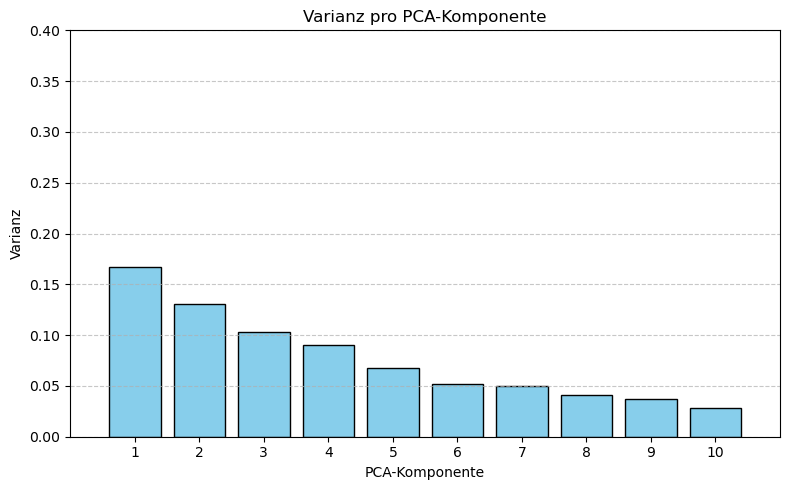

In [13]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
components = np.arange(1, 11)
plt.bar(components, explained_variance[:10], color='skyblue', edgecolor='black')
plt.xlabel('PCA-Komponente')
plt.ylabel('Varianz')
plt.xlim(0,11)
plt.title('Varianz pro PCA-Komponente')
plt.xticks(components)
plt.ylim(0, 0.4)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Variance_PCA.png")
plt.show()

In [14]:
import pickle

# File path to save
save_path = "features_pca_numbers_clip.pkl"

# Save features, labels, group names
with open(save_path, "wb") as f:
    pickle.dump({
        "features": reduced,         # PCA-reduced features
        "labels": labels,            # folder-based labels
        "paths": image_input_paths,
        "group_names": np.unique(labels).tolist()  # optional
    }, f)

print(f"Saved feature data to {save_path}")

Saved feature data to features_pca_numbers_clip.pkl


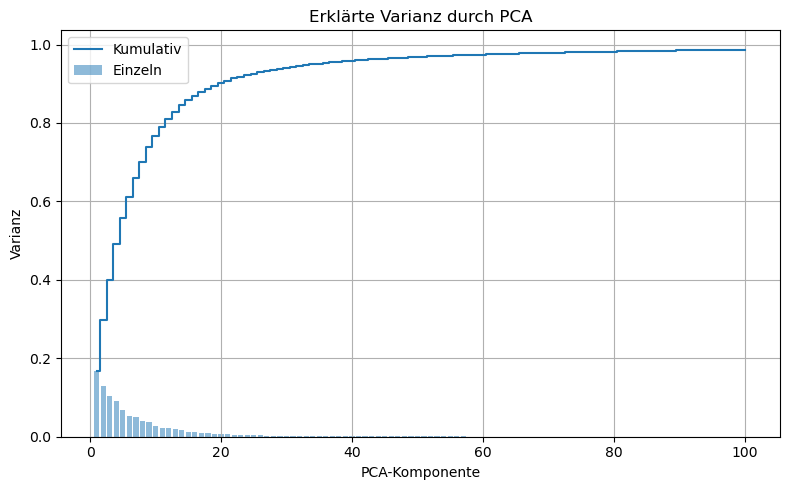

In [15]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_exp) + 1), var_exp, alpha=0.5, align='center', label='Einzeln')
plt.step(range(1, len(cum_var_exp) + 1), cum_var_exp, where='mid', label='Kumulativ')
plt.ylabel('Varianz')
plt.xlabel('PCA-Komponente')
plt.legend(loc='best')
plt.title('Erklärte Varianz durch PCA')
plt.grid(True)
plt.tight_layout()
plt.savefig("Kumulative Varianz.png")
plt.show()


In [16]:
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category20, turbo
from PIL import Image
from io import BytesIO
import base64
import os
import numpy as np

# Convert image to base64 thumbnail
def image_to_base64(path):
    img = Image.open(path).convert("RGB")
    img.thumbnail((128, 128))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode()

thumbnails = [f"data:image/png;base64,{image_to_base64(p)}" for p in image_input_paths]

unique_labels = sorted(set(labels))
n_labels = len(unique_labels)


palette = turbo(n_labels) if n_labels > 20 else Category20[n_labels]
label_to_color = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}


output_file("umap_by_label_with_legend.html")

p = figure(title="UMAP of Coin Images Colored by Folder Label (With Legend)",
           tools="pan,wheel_zoom,reset,save",
           width=1000, height=800)


hover = HoverTool(tooltips="""
    <div>
        <div><strong>@filename</strong> (@label)</div>
        <img src="@imgs" alt="image" style="width:64px;height:64px;" />
    </div>
""")
p.add_tools(hover)

# plot one glyph per label for proper legend entries
for label in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    data = dict(
        x=X_tsne[idxs, 0],
        y=X_tsne[idxs, 1],
        imgs=[thumbnails[i] for i in idxs],
        filename=[os.path.basename(image_input_paths[i]) for i in idxs],
        label=[label] * len(idxs),
    )
    source = ColumnDataSource(data)
    p.scatter('x', 'y', size=10, source=source,
             fill_color=label_to_color[label],
             line_color=None, fill_alpha=0.7,
             legend_label=label)

p.legend.location = "top_right"
p.legend.click_policy = "hide"
p.legend.label_text_font_size = "10pt"

show(p)

[Parent 108969, Main Thread] WARNING: Failed to mkdir /home/alexander/snap/firefox/6495/.config/ibus/bus: Not a directory: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:108969): IBUS-WARNING **: 17:37:43.571: Failed to mkdir /home/alexander/snap/firefox/6495/.config/ibus/bus: Not a directory
